In [1]:
# 分类与回归
# 分类预测离散类别  回归估计连续值

蓝色是损失函数 
绿色是似然函数
黄色是梯度

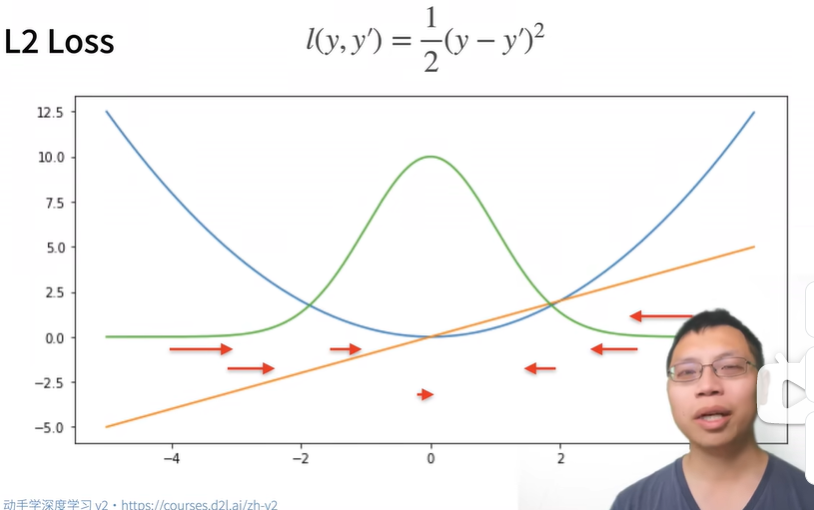

离原点较远时，梯度较大，更新速度较快，故我们考虑绝对值损失函数
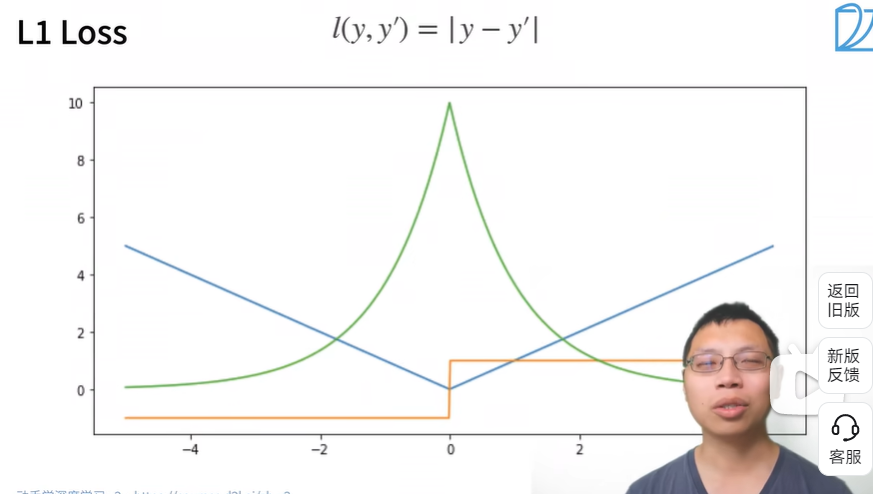
但是优化末期，其梯度还为1，故不稳定

Huber's Robust Loss
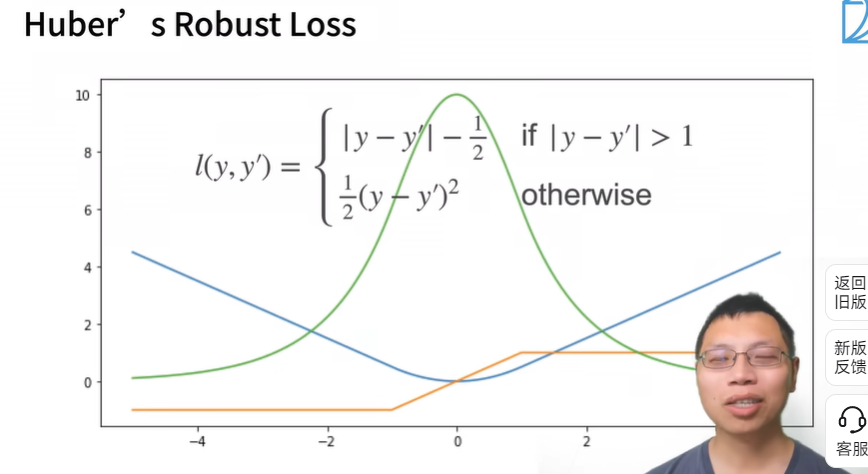

In [2]:
# 1 图像分类数据集


In [3]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display() # ?

In [4]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

100.0%


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw




100.0%

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [6]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [9]:
mnist_train[0][0].shape # 黑白， 长宽都为28

torch.Size([1, 28, 28])

In [10]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

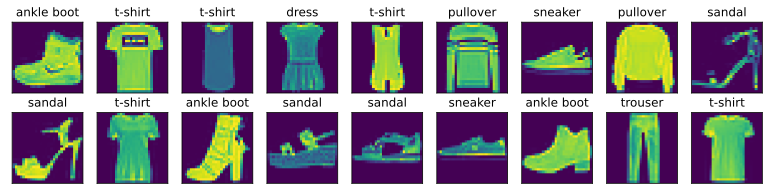

In [11]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [12]:
# 从零开始实现softmax

In [13]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [14]:
num_inputs = 784 # 28*28 = 784 拉长
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [15]:
# 给定一个矩阵，我们可以对所有元素求和
X = torch.tensor([[1.,2,3],[4.,5,6]])
X.sum(0, keepdim=True),X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [16]:
# 实现softmax
# 每一行实现一个softmax
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1,keepdim=True)
    return X_exp / partition # 使用广播机制

In [17]:
# 验证一下
X = torch.normal(0, 1, (2, 5))

In [18]:
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.3953, 0.1246, 0.2738, 0.0613, 0.1450],
         [0.3821, 0.1092, 0.2550, 0.0249, 0.2287]]),
 tensor([1.0000, 1.0000]))

In [19]:
# 实现softmax回归模型
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [20]:
#创建一个数据y_hat,其中包含2个样本在3个类别中的预测概率，
#使用y作为y_hat中概率的索引
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1,0.3,0.6],[0.3, 0.2, 0.5]])
y_hat[[0,1], y]

tensor([0.1000, 0.5000])

In [21]:
# 实现交叉熵损失函数
def cross_entropy(y_hat, y):
    # 例如 
    return -torch.log(y_hat[range(len(y_hat)), y]) 

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [22]:
# 将预测类别与真实元素y作比较
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y # 数值类型转换
    return float(cmp.type(y.dtype).sum())
accuracy(y_hat, y)/len(y)

0.5

In [25]:
# 我们可以评估在任意模型net的准确率
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() #将模型设为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X),y),y.numel())
    return metric[0] / metric[1]

In [24]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]